In [1]:
import keras
import sys
import zipfile # для работы с архивами 
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import csv
import tensorflow as tf
from PIL import Image
import os
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
from matplotlib.pyplot import imread
from PIL import Image
from tensorflow.keras.preprocessing import image as im
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [5]:
train_path = "/home/linnik/My_Datasets/train/"
test_path = "/home/linnik/My_Datasets/val/"

In [7]:
class_names = os.listdir(train_path)
print(len(class_names))

43


In [8]:
Train = pd.read_csv("Train_GOST.csv")
Test = pd.read_csv("Test_GOST.csv")

print(Train.shape)
Train.head(10)

(26640, 10)


,Unnamed: 0,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,GOST
0,0,00000_00000.ppm,29,30,5,6,24,25,0,3.24.20
1,1,00000_00001.ppm,30,30,5,5,25,25,0,3.24.20
2,2,00000_00002.ppm,30,30,5,5,25,25,0,3.24.20
3,3,00000_00003.ppm,31,31,5,5,26,26,0,3.24.20
4,4,00000_00004.ppm,30,32,5,6,25,26,0,3.24.20
5,5,00000_00005.ppm,31,31,6,6,26,26,0,3.24.20
6,6,00000_00006.ppm,33,34,6,6,28,28,0,3.24.20
7,7,00000_00007.ppm,34,35,6,6,29,30,0,3.24.20
8,8,00000_00008.ppm,33,34,5,5,28,29,0,3.24.20
9,9,00000_00009.ppm,36,36,6,5,30,30,0,3.24.20


In [9]:
print(Test.shape)
Test.head(10)

(12630, 10)


,Unnamed: 0,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,GOST
0,0,00000.ppm,53,54,6,5,48,49,16,3.4
1,1,00001.ppm,42,45,5,5,36,40,1,3.24.30
2,2,00002.ppm,48,52,6,6,43,47,38,4.2.1
3,3,00003.ppm,27,29,5,5,22,24,33,4.1.2
4,4,00004.ppm,60,57,5,5,55,52,11,none1
5,5,00005.ppm,52,56,5,5,47,51,38,4.2.1
6,6,00006.ppm,147,130,12,12,135,119,18,1.30
7,7,00007.ppm,32,33,5,5,26,28,12,2.1
8,8,00008.ppm,45,50,6,5,40,45,25,1.23
9,9,00009.ppm,81,86,7,7,74,79,35,4.1.1


In [10]:
G = ["3.24.20", "3.24.30", "3.24.50", "3.24.60", "3.24.70", "3.24.80", "3.25.80", "3.24.100", "3.24.120", "3.20", "3.22", 
"none1", "2.1", "2.4", "2.5", "3.2", "3.4", "3.1", "1.30", "1.12", "1.11", "1.12.2", "1.16", "1.15", "1.18.2", "1.23", "1.8", 
"none3", "1.21", "1.24", "none2", "1.25", "3.31", "4.1.2", "4.1.3", "4.1.1", "4.1.4", "4.1.5", "4.2.1", "4.2.2", "4.3", "3.21",
"3.23"]

In [13]:
df = pd.DataFrame(index = range(43), columns = ["ClassId", "GOST", "Precison", "Recall"])
df["ClassId"] = range(43)
df["GOST"] = G
df["Precison"] = 0
df["Recall"] = 0
df.head()

,ClassId,GOST,Precison,Recall
0,0,3.24.20,0,0
1,1,3.24.30,0,0
2,2,3.24.50,0,0
3,3,3.24.60,0,0
4,4,3.24.70,0,0


In [188]:
df.to_csv("Classification_Benchmark_DenseNet121.csv")

In [14]:
#int(Test[Test["Filename"] == "00000.ppm"]["ClassId"])

Fload_GOST_1 = {}
for i in range(len(Test)):
    try:
        Fload_GOST_1[int(Test[Test["Unnamed: 0"] == i]["ClassId"])] = str(Test[Test["Unnamed: 0"] == i]["GOST"])[5:-26]
    except:
        pass

In [16]:
#Fload_GOST_1

In [18]:
Fload_GOST = [i - i for i in range(len(class_names))]

for i in Fload_GOST_1:
    Fload_GOST[i] = Fload_GOST_1[i]
    
#Fload_GOST

In [19]:
img_width, img_height = 50, 50
nb_train_samples = 26640
nb_validation_samples = 12630
epochs = 50
batch_size = 8
n_classes = 43

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    #shear_range=0.2,
    zoom_range=0.2,
    #fill_mode = 'constant',
    #cval = 1,
    rotation_range = 5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = False,
    vertical_flip = False)

In [21]:
test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

In [22]:
def build_model_DenseNet():
    base_model = densenet.DenseNet121(include_top=True, 
                                      weights = None,
                                      input_tensor = None,
                                      input_shape = (img_width, img_height, 3),
                                      pooling = None,
                                      classes = 43)
    
    for layer in base_model.layers:
        layer.trainable = True

    model = Model(inputs = base_model.input, outputs = base_model.output)
    return model

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
   test_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 26640 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [25]:
model = build_model_DenseNet()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc', 'mse'])

W1015 16:05:23.903975 140546641590080 deprecation_wrapper.py:119] From /home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1015 16:05:23.933647 140546641590080 deprecation_wrapper.py:119] From /home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1015 16:05:23.958136 140546641590080 deprecation_wrapper.py:119] From /home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1015 16:05:23.992880 140546641590080 deprecation_wrapper.py:119] From /home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Pl

In [14]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 8, verbose=1, min_delta = 1e-4) # остановка обучения, если loss на валидационном множесте улучшается менее чем на 10^-4
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1, min_delta = 1e-4)
check = ModelCheckpoint("Best_DenseNet121_50_epochs.hdf5", monitor = "val_acc", save_best_only = True) # сохранение лучшей (с наибольшим acc на валидационном множестве) сети
callbacks_list = [early_stop, reduce_lr, check]

In [15]:
model_history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size,
    callbacks = callbacks_list,
    steps_per_epoch = nb_train_samples // batch_size)

W0717 10:51:32.349391 140418786912064 deprecation.py:323] From /home/intern01/.conda/envs/NikL/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
3330/3330 [==============================] - 409s 123ms/step - loss: 2.6799 - acc: 0.2663 - mean_squared_error: 0.0197 - val_loss: 1.3993 - val_acc: 0.5467 - val_mean_squared_error: 0.0131
Epoch 2/50
3330/3330 [==============================] - 378s 113ms/step - loss: 0.9696 - acc: 0.6953 - mean_squared_error: 0.0095 - val_loss: 0.4996 - val_acc: 0.8497 - val_mean_squared_error: 0.0051
Epoch 3/50
3330/3330 [==============================] - 379s 114ms/step - loss: 0.3546 - acc: 0.8877 - mean_squared_error: 0.0038 - val_loss: 0.2897 - val_acc: 0.9167 - val_mean_squared_error: 0.0028
Epoch 4/50
3330/3330 [==============================] - 369s 111ms/step - loss: 0.2022 - acc: 0.9371 - mean_squared_error: 0.0021 - val_loss: 0.2635 - val_acc: 0.9282 - val_mean_squared_error: 0.0025
Epoch 5/50
3330/3330 [==============================] - 380s 114ms/step - loss: 0.1465 - acc: 0.9566 - mean_squared_error: 0.0015 - val_loss: 0.2439 - val_acc: 0.9331 - val_mean_squared_error: 0.0023


In [26]:
# Проверим, что веса лучшей сети сохранились
!ls

DenseNet121.ipynb      Ice_Vision_Crop.ipynb  TrafficLights.ipynb
Efficientnet-b0.ipynb  ShuffleNet.ipynb       Train_GOST.csv
Ice_Vision_crop.ipynb  Test_GOST.csv


In [9]:
# Загрузка модели
loaded_model = load_model("Best_DenseNet121_50_epochs.hdf5")

# Описание о модели
print(loaded_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 25, 25, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

<class 'PIL.Image.Image'>
(50, 50)


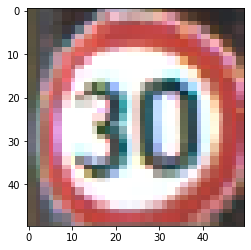

(1, 50, 50, 3)
<class 'numpy.ndarray'>
float32
1


In [10]:
img_path = "Test_cut_Like_Train/00001/00001.png"

img = im.load_img(img_path, target_size = (img_width, img_height))
print(type(img))
print(img.size)

plt.imshow(img)
plt.show()

x = im.img_to_array(img)#.astype("uint8")
x = np.expand_dims(x, axis=0)
x /= 255

print(x.shape)
print(type(x))
print(x.dtype)

ans = np.argmax(loaded_model.predict(x))
print(ans)

In [11]:
start_time = time.time()
print("Predicted class is", np.argmax(loaded_model.predict(x)))
print("Time to predict an image is", (time.time() - start_time), "seconds")

Predicted class is 1
Time to predict the image is 0.0340425968170166 seconds


In [10]:
# Проверка качества сети (accuracy)

right = 0
wrong = 0
times = []

for folder in os.listdir("Test_cut_Like_Train"):
    for img in os.listdir("Test_cut_Like_Train/" + folder):
        imag = im.load_img("Test_cut_Like_Train/" + folder + "/" + img, target_size = (img_width, img_height))
        
        photo_ar = im.img_to_array(imag)
        photo_ar = np.expand_dims(photo_ar, axis = 0)
        photo_ar /= 255
        
        start_time = time.time()
        ans = np.argmax(loaded_model.predict(photo_ar))
        times.append(time.time() - start_time)
        
        if ans == int(folder):
            right += 1
        else:
            wrong += 1

In [11]:
print("Accuracy on validation set is", right/(right + wrong))
print("Average time to pridict one photo is", np.array(times).mean(), "seconds")

Accuracy on validation set is 0.9907363420427553
Average time to pridict one photo is 0.027952802530471426 seconds


In [15]:
# Проверка качества сети по классам (Precision and Recall)

TP = [i - i for i in range(len(class_names))]
FN = [i - i for i in range(len(class_names))]
FP = [i - i for i in range(len(class_names))]

precision = [i - i for i in range(len(class_names))]
recall = [i - i for i in range(len(class_names))]

for folder in os.listdir("Test_cut_Like_Train"):
    for photo in os.listdir("Test_cut_Like_Train/" + folder):
        imag = im.load_img("Test_cut_Like_Train/" + folder + "/" + photo, target_size = (img_width, img_height))
        
        photo_ar = im.img_to_array(imag)
        photo_ar = np.expand_dims(photo_ar, axis = 0)
        photo_ar /= 255
        
        ans = np.argmax(loaded_model.predict(photo_ar))
    
        if ans == int(folder):
            TP[ans] += 1
        if ans != int(folder):
            FN[ans] += 1
            FP[int(folder)] += 1

In [17]:
for i in range(len(class_names)):
    precision[i] = TP[i]/(TP[i] + FP[i])
    recall[i] = TP[i]/(TP[i] + FN[i]) 
    
precision = np.array(precision)
recall = np.array(recall)

print(precision.max(), precision.min(), precision.mean())
print(recall.max(), recall.min(), recall.mean())

1.0 0.8333333333333334 0.9858245173262866
1.0 0.9081632653061225 0.985720743446564


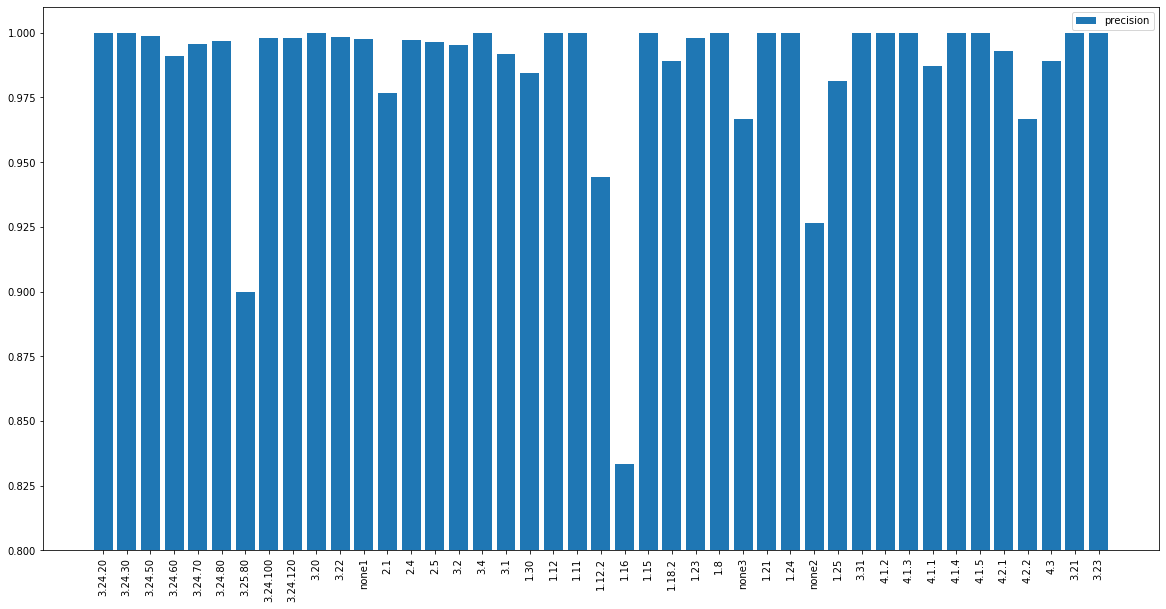

In [151]:
# Визуализируем 

plt.figure(figsize = (20,10))
x = range(len(precision))
ax = plt.gca()
ax.bar(Fload_GOST, precision - 0.8,  bottom = 0.8, label = "precision", ) # align='edge' - выравнивание по границе, а не по центру
plt.legend(loc = 'best')
#ax.set_xticks(x)
plt.xticks(rotation='vertical')
plt.show()

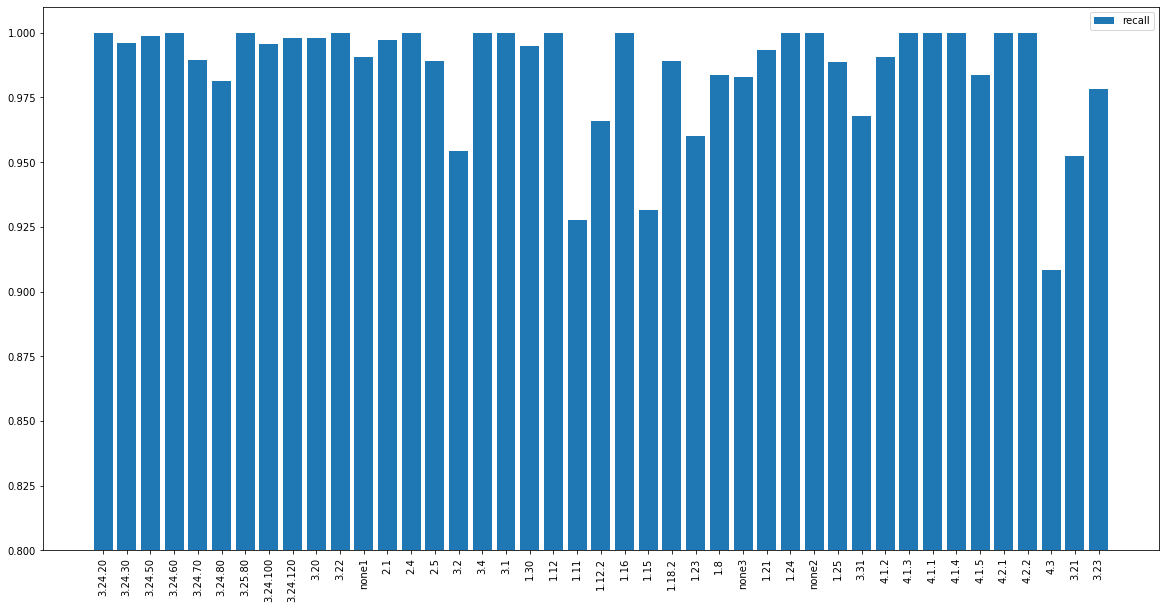

In [152]:
plt.figure(figsize = (20,10))
ax = plt.gca()
ax.bar(Fload_GOST, recall - 0.8, bottom = 0.8, label = "recall") # align='edge' - выравнивание по границе, а не по центру
plt.legend(loc='best')
ax.set_xticks(x)
plt.xticks(rotation='vertical')
plt.show()